In [754]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

In [755]:
events = pd.read_csv("events.csv", low_memory=False)

euro = events[events['competition_season'] == "UEFA Euro_2020"]
cdm = events[events['competition_season'] == "FIFA World Cup_2022"]
cdm_final = cdm[cdm['match_date'] == "2022-12-18"]





In [821]:
events22 = pd.read_csv("events_WC22.csv", low_memory=False)
df = events22

In [928]:
df = events.sort_index()

In [929]:
df = df[df["type.name"].isin(["Pass","Carry", "Clearance", "Dribble", "Shot", "Dispossessed", "Ball Recovery"])]
df = df[df["period"] <= 4]

## Create the possesion 2

In [930]:
df["possession_2"] = df["possession"].copy()

for i in df["possession_2"].unique():
    sub = df[df["possession_2"] == i]

    if "Shot" in sub["type.name"].unique() and sub["type.name"].value_counts()["Shot"] > 1:
        shot_part = sub[sub["type.name"] == "Shot"].index

        for idx in shot_part[:-1]:
            df.loc[idx+2:, "possession_2"] += 1

## PSV

In [939]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
df['PSV'] = .0

for match in df['match_id'].unique():
    # Identifier les indices des tirs dans le dataframe
    shoot_indices = df[(df['type.name'] == 'Shot') & (df["match_id"] == match)].index

    # Calculer le PSV pour chaque séquence de possession
    for idx in shoot_indices:
        possession_idx = df.loc[idx, 'possession_2']
        possession_events = df[df['possession_2'] == possession_idx]

        # Calculer le PSV pour la séquence de possession
        total_xG = df.loc[idx]['shot.statsbomb_xg'].astype(float)
        df.loc[(df['possession_2'] == possession_idx) & (df["match_id"] == match ), 'PSV'] = total_xG

In [940]:
df["PSV"].describe()

count    1.334980e+06
mean     1.807202e-02
std      6.781500e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.861261e-01
Name: PSV, dtype: float64

In [941]:
df[df["possession_2"]== 203][["possession_2", "type.name", "shot.statsbomb_xg", "PSV", "match_id"]]

,possession_2,type.name,shot.statsbomb_xg,PSV,match_id
6086,203,Pass,NaN,0.000000,3827335
6088,203,Pass,NaN,0.000000,3827335
6090,203,Pass,NaN,0.000000,3827335
6092,203,Carry,NaN,0.000000,3827335
6093,203,Pass,NaN,0.000000,3827335
11218,203,Ball Recovery,NaN,0.000000,3827338
11219,203,Pass,NaN,0.000000,3827338
11221,203,Pass,NaN,0.000000,3827338
11223,203,Carry,NaN,0.000000,3827338
11224,203,Pass,NaN,0.000000,3827338


In [853]:
df[["minute","possession", "possession_2", "player.name", "type.name", "PSV", "shot.statsbomb_xg"]].iloc[4050:4070]

,minute,possession,possession_2,player.name,type.name,PSV,shot.statsbomb_xg
7129,91,147,183,Cristian Gabriel Romero,Pass,0.0000,0.0000
7131,91,147,183,Mathew Ryan,Ball Recovery,0.0000,0.0000
7132,91,147,183,Mathew Ryan,Carry,0.0000,0.0000
7133,91,147,183,Mathew Ryan,Pass,0.0000,0.0000
7134,91,147,183,Nicolás Hernán Otamendi,Clearance,0.0000,0.0000
7135,91,147,183,Nicolás Alejandro Tagliafico,Pass,0.0000,0.0000
7137,91,147,183,Fran Karačić,Pass,0.0000,0.0000
7138,92,148,184,Nicolás Alejandro Tagliafico,Pass,0.0000,0.0000
7140,92,148,184,Fran Karačić,Ball Recovery,0.0000,0.0000
7141,92,148,184,Lionel Andrés Messi Cuccittini,Ball Recovery,0.0000,0.0000


## xT

In [854]:
obv_type= ['Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Foul Committed', 'Foul Won', 'Ball Recovery', 'Block',
       'Miscontrol', 'Clearance', 'Duel', 'Interception', 'Dribble',
       'Shot', 'Goal Keeper', 'Dispossessed', 'Dribbled Past','Offside']

In [855]:
df = df[df["type.name"].isin(obv_type)]

In [867]:
df["x"] = df["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
df["y"] = df["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)

In [868]:
prob_rows = np.array([
    [0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8, 1, 1.3, 1.8, 2.5, 3.7, 4.8, 6, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.7, 0.8, 1.1, 1.5, 2, 2.9, 4.2, 5.6, 7.5, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.6, 0.7, 0.9, 1.2, 1.6, 2.2, 3.4, 4.6, 6.8, 9.4, 10.3],
    [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.3, 3.4, 4.6, 6.8, 9.9, 12.3],
    [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 1, 1.3, 1.7, 2.5, 3.4, 4.8, 6.8, 12.6, 15.8],
    [0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 0.9, 1.3, 1.7, 2.5, 3.3, 5.2, 8.9, 17.1, 41]
])

# Mirror the probabilities to create a full 12x16 grid
xT_values = np.vstack((prob_rows, np.flipud(prob_rows)))

# Normalize the probabilities to a scale of 0-1 (dividing by 100 since they were given as percentages)
xT_values /= 100

# Function to map location to xT value
def map_location_to_xT(x,y, xT_values):
    # Map the x and y coordinates to the xT grid
    xT_x = min(int(np.floor(float(x) / 120 * 16)), 15)
    xT_y = min(int(np.floor(float(y) / 80 * 12)), 11)
    return xT_values[xT_y, xT_x]

# Apply the function to the DataFrame
df['xT'] = df.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)

In [866]:
df.loc[(df["pass.outcome.name"].isnull())& (df["type.name"] == "Pass"), "pass.outcome.name"] = "Complete"
df.loc[(df["pass.outcome.id"].isnull()) & (df["type.name"] == "Pass"), "pass.outcome.id"] = 8.

In [869]:
def get_outcome(row):
    if row["type.name"] == "Pass":
        return row["pass.outcome.name"]
    elif row["type.name"] == "Dribble":
        return row["dribble.outcome.name"]
    elif row["type.name"] == "Shot":
        return row["shot.outcome.name"]
    else:
        return None
    
df["outcome"] = df.apply(get_outcome, axis=1)

In [870]:
def get_end_location(row):
    if pd.notnull(row['pass.end_location']):
        return row['pass.end_location']

    elif pd.notnull(row['shot.end_location']):
        return row['shot.end_location']

    elif pd.notnull(row['carry.end_location']):
        return row['carry.end_location']

    elif row["type.name"] == "Dribble":
        # return end_location of next event
        row_index = row.name
        next_index = row_index + 1

        if next_index in df.index:  # Vérifie si le prochain index existe
            next_event = df.loc[next_index]
            return next_event.get("carry.end_location")
    else:
        return row['location']

def remove_brackets(x):
    if x[-1] == "]":
        return x[:-1]
    elif x[0] == "[":
        return x[1:]
    else:  
        return x

df['end_location'] = df.apply(get_end_location, axis=1)
df['end_x'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[0])) if pd.notnull(row['end_location']) else None, axis=1)
df['end_y'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[1])) if pd.notnull(row['end_location']) else None, axis=1)

df['end_z'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[-1])) if pd.notnull(row['end_location']) and row['type.name'] == 'Shot' else 0, axis=1)


df['xT.end'] = df.apply(lambda row: map_location_to_xT(row['end_x'], row['end_y'], xT_values) if pd.notnull(row['end_location']) else None, axis=1)

In [837]:
df.iloc[230:240][["type.name", "player.name", "outcome", "end_location", "carry.end_location", "end_x", "end_y", "end_z", "xT", "xT.end"]]

,type.name,player.name,outcome,end_location,carry.end_location,end_x,end_y,end_z,xT,xT.end
403,Carry,Saša Lukić,None,"[49.7, 50.4]","[49.7, 50.4]",49.7,50.4,0.0,0.005,0.006
404,Pass,Saša Lukić,Incomplete,"[53.5, 44.6]",NaN,53.5,44.6,0.0,0.006,0.008
407,Ball Recovery,Filip Kostić,None,"[69.5, 2.6]",NaN,69.5,2.6,0.0,0.010,0.010
408,Carry,Filip Kostić,None,"[79.4, 3.1]","[79.4, 3.1]",79.4,3.1,0.0,0.010,0.013
409,Pass,Filip Kostić,Complete,"[76.2, 5.5]",NaN,76.2,5.5,0.0,0.013,0.013
411,Carry,Dušan Tadić,None,"[80.4, 4.9]","[80.4, 4.9]",80.4,4.9,0.0,0.013,0.013
412,Pass,Dušan Tadić,Incomplete,"[87.0, 7.5]",NaN,87.0,7.5,0.0,0.013,0.020
415,Pass,Silvan Widmer,Complete,"[10.4, 49.6]",NaN,10.4,49.6,0.0,0.004,0.004
417,Pass,Manuel Obafemi Akanji,Out,"[29.3, 80.0]",NaN,29.3,80.0,0.0,0.004,0.003
418,Pass,Filip Kostić,Complete,"[74.0, 3.3]",NaN,74.0,3.3,0.0,0.025,0.010


In [838]:
df = df[df["type.name"] != "Ball Receipt*"]

## Model

In [839]:
list(df.columns)

['match_id', 'competition_season', 'match_date', 'match_outcome', 'id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'type.id', 'type.name', 'possession_team.id', 'possession_team.name', 'play_pattern.id', 'play_pattern.name', 'team.id', 'team.name', 'tactics.formation', 'tactics.lineup', 'related_events', 'location', 'player.id', 'player.name', 'position.id', 'position.name', 'pass.recipient.id', 'pass.recipient.name', 'pass.length', 'pass.angle', 'pass.height.id', 'pass.height.name', 'pass.end_location', 'pass.body_part.id', 'pass.body_part.name', 'pass.type.id', 'pass.type.name', 'carry.end_location', 'pass.cross', 'pass.outcome.id', 'pass.outcome.name', 'ball_receipt.outcome.id', 'ball_receipt.outcome.name', 'under_pressure', 'clearance.right_foot', 'clearance.body_part.id', 'clearance.body_part.name', 'shot.statsbomb_xg', 'shot.end_location', 'shot.technique.id', 'shot.technique.name', 'shot.body_part.id', 'shot.body_part.name', 'shot.type.id', 'sh

In [871]:
df.fillna(0, inplace=True)


In [872]:
## create a feature distance to goal
df['distance_to_goal'] = ((df['x'] - 120)**2 + (df['y'] - 40)**2)**0.5

## angle to goal (posts)
a2 = ((df['x'] - 120)**2 + (df['y'] - 40-3.66)**2)
c2 = ((df['x'] - 120)**2 + (df['y'] - 40 + 3.66)**2)
df['angle_to_goal'] = np.degrees(np.arccos((a2 + c2 - (7.3)**2)/(2*(a2**0.5)*(c2**0.5))))


/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_50390/2158508925.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['distance_to_goal'] = ((df['x'] - 120)**2 + (df['y'] - 40)**2)**0.5
/Users/thomassinapi/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/hy/27t6v09s54x9lv_68y2yk65w0000gn/T/ipykernel_50390/2158508925.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['angle_to_

In [918]:
# Select the columns to drop
column_name = df.columns[df.columns.str.endswith("name")]
end_location = df.columns[df.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start", "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation",
                                            "player.id", "pass.recipient.id",
                                           "related_events", "location", "PSV", "shot.aerial_won",
                                           "shot.statsbomb_xg",
                                            "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = df.drop(to_drop, axis=1)
y = df["PSV"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [845]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict the PSV
y_pred = rf.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.093193602877279


In [847]:
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.049866497032265866


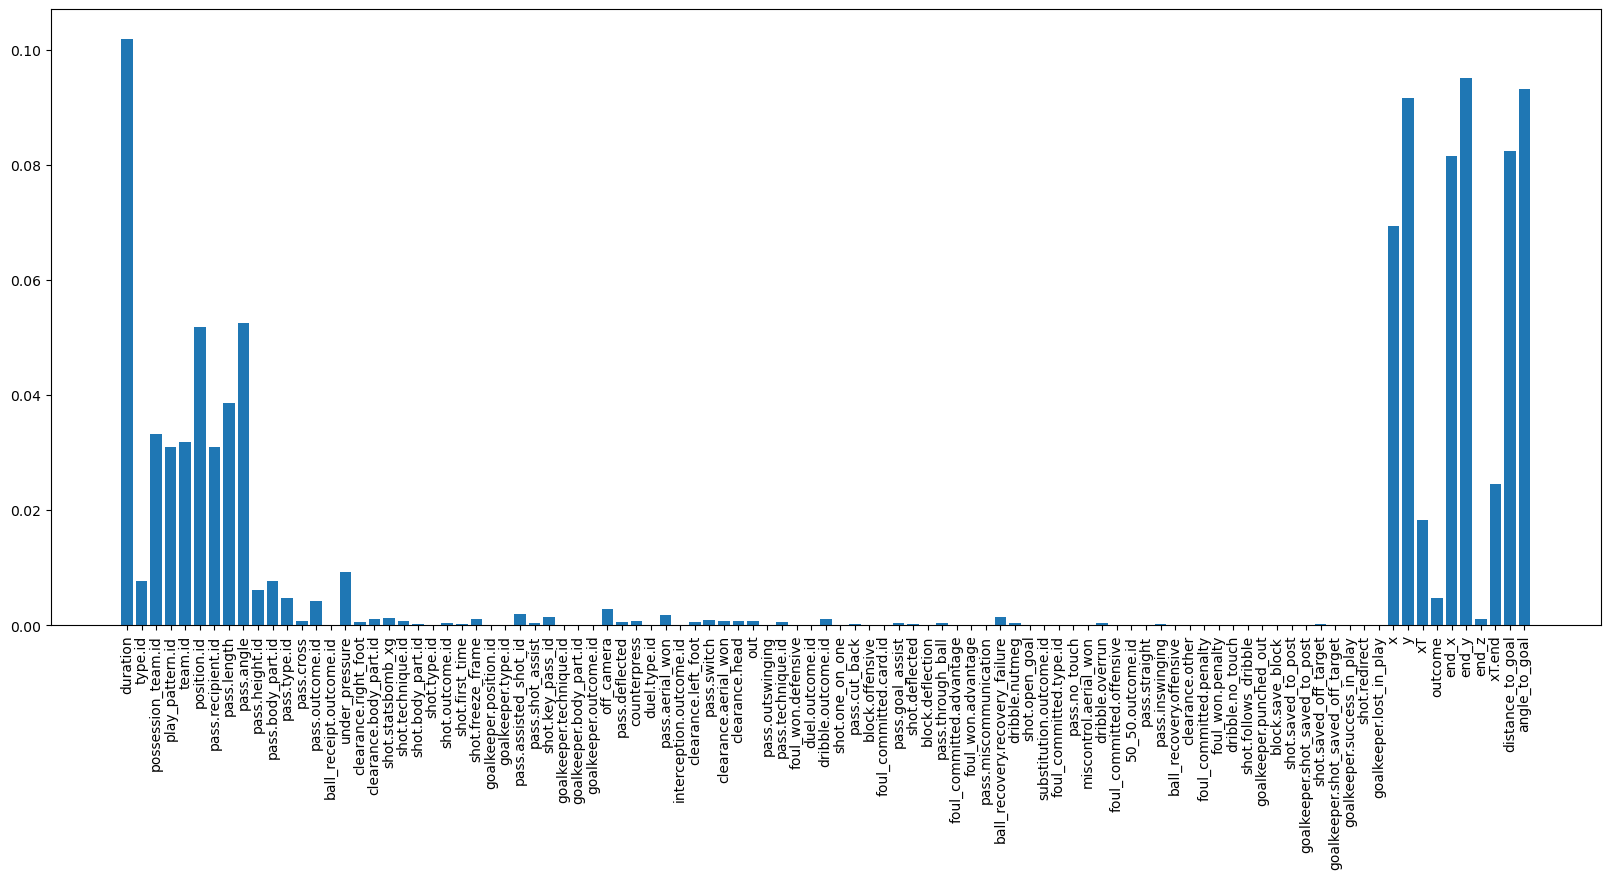

In [846]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, rf.feature_importances_)

plt.xticks(rotation=90)
plt.show()

In [919]:
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the PSV
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 4.421523635240121e-05
R2 Score: 0.8976330144430833


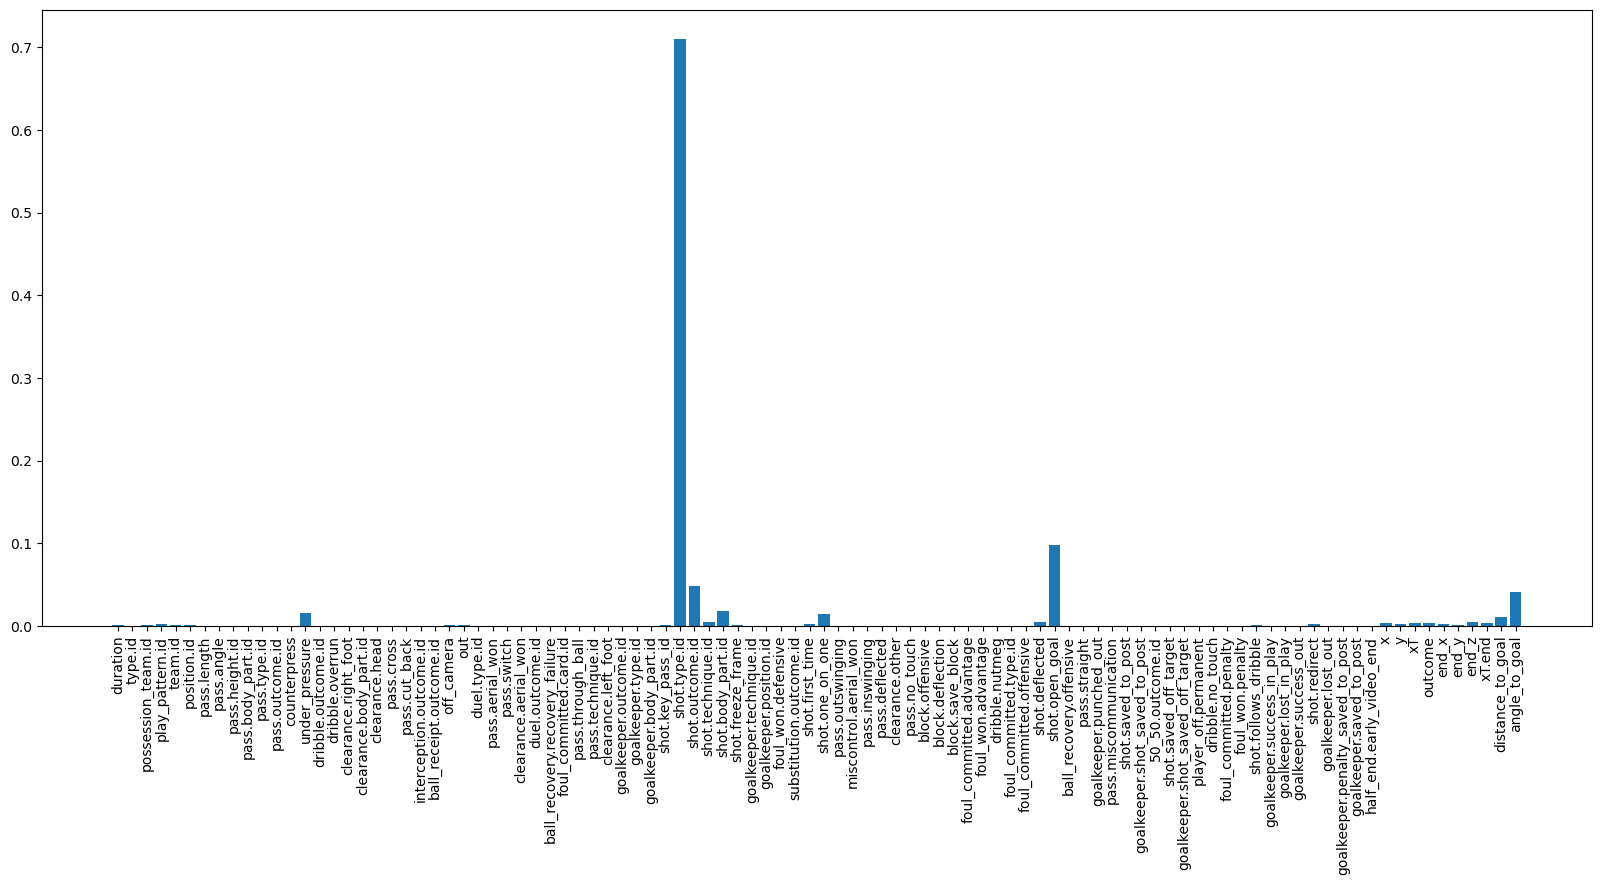

In [909]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [530]:
df["type.name"].value_counts()  

type.name
Pass             68515
Carry            53764
Ball Recovery     5821
Clearance         2684
Dribble           1793
Shot              1453
Dispossessed      1431
Name: count, dtype: int64

In [561]:
r2_score(y_test, y_pred)

0.16298867089905933

In [562]:
X_test["pred"] = y_pred

In [563]:
X_test["true"] = y_test

In [564]:
X_test[["type.id", "xT", "xT.end", "shot.statsbomb_xg", "pred", "true"]].head(110)

,type.id,xT,xT.end,shot.statsbomb_xg,pred,true
882093,43,0.042,0.068,0.000000,0.022996,0.074439
400488,43,0.006,0.006,0.000000,0.012850,0.000000
1690489,43,0.004,0.004,0.000000,0.012367,0.000000
325005,30,0.004,0.004,0.000000,0.008768,0.069583
591485,30,0.004,0.005,0.000000,0.019431,0.000000
729701,43,0.003,0.003,0.000000,-0.002593,0.000000
1076935,43,0.017,0.025,0.000000,0.019441,0.139977
1828057,30,0.012,0.034,0.000000,0.032153,0.000000
1055857,16,0.068,0.171,0.033629,0.043706,0.033629
1321424,43,0.013,0.012,0.000000,0.022108,0.000000


In [916]:
passes = df[df["type.name"] != "Shot"]

column_name = passes.columns[passes.columns.str.endswith("name")]
end_location = passes.columns[passes.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", "period", "player.id", "player.name",
                                           "substitution.replacement.id", "substitution.replacement.name",
                                           "match_outcome", "minute", "second", "possession", "possession_2",
                                           "competition_season", "timestamp", "half_start.late_video_start", "injury_stoppage.in_chain", "bad_behaviour.card.id",
                                           "tactics.lineup", "tactics.formation", "pass.recipient.id",
                                           "related_events", "location", "PSV", "shot.aerial_won",
                                           "shot.statsbomb_xg",
                                            "pass.shot_assist", "pass.goal_assist", "pass.assisted_shot_id"
                                           ]


# Select the features and the target
X = passes.drop(to_drop, axis=1)
y = passes["PSV"]

# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [912]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [913]:
# Create the model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Mean Squared Error: 0.0
R2 Score: 1.0


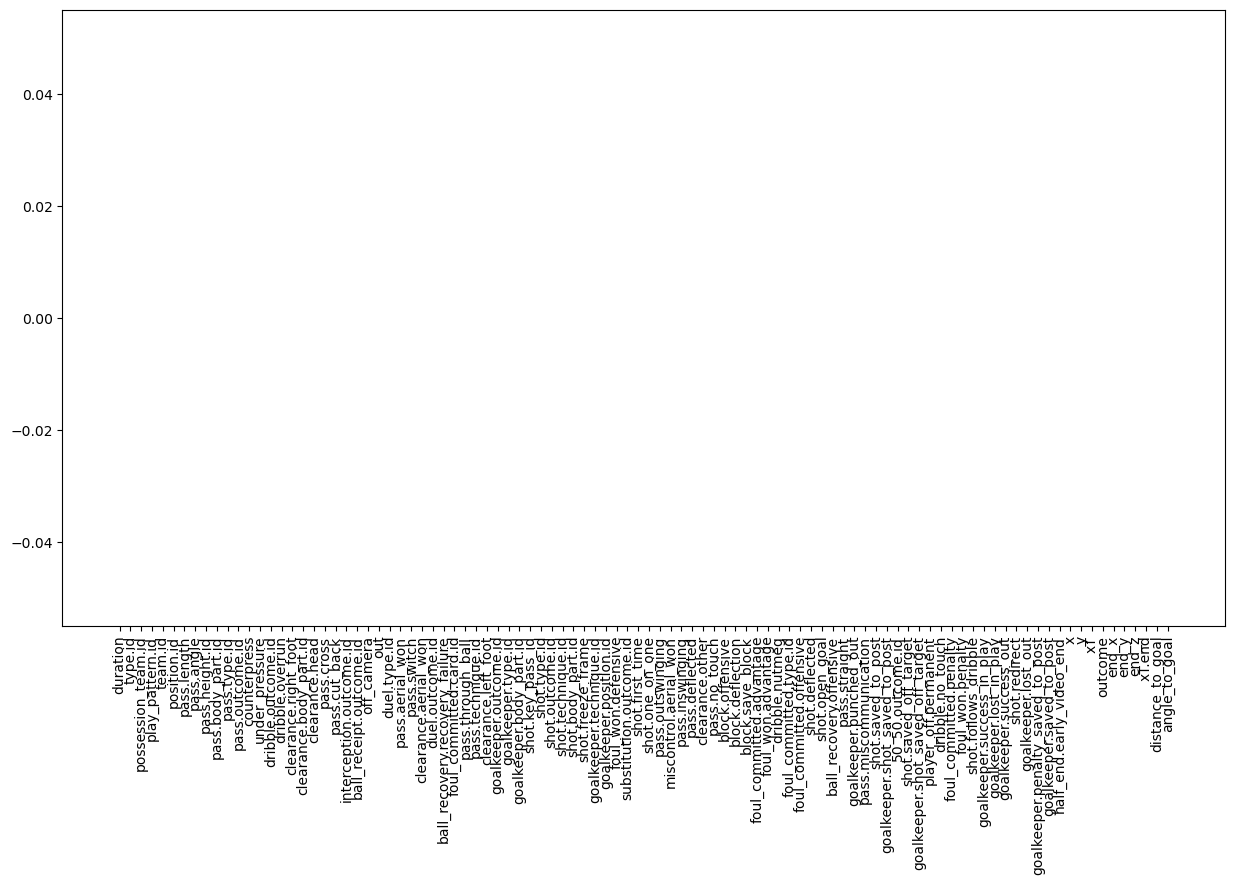

In [915]:

# Predict the PSV
y_pred = xgb.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.show()


## Cross Validation

In [570]:
y_cv = cross_val_predict(xgb, X_train, y_train, cv=5)

In [593]:
obv1 = xgb.predict(X)

In [597]:
r2_score(y, obv1)

0.11270937542555959

In [600]:
X["OBV"] = obv1
X["PSV"] = y

In [601]:
X

,duration,type.id,possession_team.id,play_pattern.id,team.id,position.id,pass.length,pass.angle,pass.height.id,pass.body_part.id,pass.type.id,pass.outcome.id,counterpress,under_pressure,dribble.outcome.id,dribble.overrun,clearance.right_foot,clearance.body_part.id,clearance.head,pass.cross,pass.cut_back,interception.outcome.id,ball_receipt.outcome.id,off_camera,out,duel.type.id,pass.aerial_won,pass.switch,clearance.aerial_won,duel.outcome.id,ball_recovery.recovery_failure,foul_committed.card.id,pass.through_ball,pass.technique.id,clearance.left_foot,goalkeeper.outcome.id,goalkeeper.type.id,goalkeeper.body_part.id,shot.statsbomb_xg,shot.key_pass_id,shot.type.id,shot.outcome.id,shot.technique.id,shot.body_part.id,shot.freeze_frame,goalkeeper.technique.id,goalkeeper.position.id,foul_won.defensive,substitution.outcome.id,shot.first_time,shot.one_on_one,pass.outswinging,miscontrol.aerial_won,pass.inswinging,pass.deflected,clearance.other,pass.no_touch,block.offensive,block.deflection,block.save_block,foul_committed.advantage,foul_won.advantage,dribble.nutmeg,foul_committed.type.id,foul_committed.offensive,shot.deflected,shot.open_goal,ball_recovery.offensive,pass.straight,goalkeeper.punched_out,pass.miscommunication,shot.saved_to_post,goalkeeper.shot_saved_to_post,50_50.outcome.id,shot.saved_off_target,goalkeeper.shot_saved_off_target,player_off.permanent,dribble.no_touch,foul_committed.penalty,foul_won.penalty,shot.follows_dribble,goalkeeper.success_in_play,goalkeeper.lost_in_play,goalkeeper.success_out,shot.redirect,goalkeeper.lost_out,goalkeeper.penalty_saved_to_post,goalkeeper.saved_to_post,half_end.early_video_end,x,y,xT,outcome,end_x,end_y,end_z,xT.end,pred,OBV,PSV
4,1.643562,30,7289,9,7289,22.0,32.635258,-2.632709,1.0,40.0,65.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0,40.0,0.009,1,31.5,24.1,0.0,0.004,0.003586,0.003586,0.0
6,1.672124,43,7289,9,7289,5.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.5,24.1,0.004,0,31.9,21.1,0.0,0.004,0.002262,0.002262,0.0
7,1.427084,30,7289,9,7289,5.0,35.322090,0.187957,3.0,38.0,0.0,9.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.9,21.1,0.004,2,66.6,27.7,0.0,0.010,0.002341,0.002341,0.0
8,2.033153,30,7283,1,7283,11.0,24.834050,-3.089221,3.0,37.0,66.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.5,52.4,0.007,1,28.7,51.1,0.0,0.004,0.010802,0.010802,0.0
10,0.812119,30,7283,1,7283,3.0,12.865847,-0.101215,2.0,37.0,0.0,8.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.7,51.1,0.004,1,41.5,49.8,0.0,0.005,0.011303,0.011303,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359995,0.000000,9,773,1,907,5.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,1,0.0,0,0,37.0,1,0,0,0.0,0.0,0,0,0.0,0,0,1,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0,37.8,0.005,0,31.